# Introduction To Phishing                                            


In [450]:
##Yumeng Liu, Parth Soni, Pratik Nandoskar, Rohit Pathak

Phishing is “a form of social engineering, characterized by attempts to fraudulently acquire sensitive information, 
such as passwords and credit card details, by masquerading as a trustworthy person or business in an apparently official 
electronic communication, such as an email or an instant message. The term phishing arises from the use of increasingly 
sophisticated lures to fish for user financial information and passwords.


# how to prevent phishing

a) User Education
b) Using Authentication
c) Network Level Protection

# Feature Extraction



a)	Lexical Features:
Lexical features are based on the observation that the URLs of many illegal sites 
look different when compared with legitimate sites. 
Analyzing lexical features enables us to capture the property for classification purposes. 
We first distinguish the two parts of a URL: the host name and the path, 
from which we extract special characters such as  (‘/’, ‘?’, ‘.’, ‘=’, ‘-’ and ‘ ’).

b)	Site popularity Features:
It has been noted that malicious sites are less popular than the benign ones. For this reason, 
site popularity can be considered as another feature. For e.g. we can get traffic rank from Alexa.com

c)	Host-based features:
This feature is based on the observation that malicious sites are always registered in less reputable hosting centers.


In [ ]:
#adding neccessary imports

In [ ]:
from urllib.parse import urlparse
import re
import urllib.request  as urllib2
import urllib
from xml.dom import minidom
import csv
import pygeoip
import requests

In [3]:
opener = urllib2.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
nf=-1

In [4]:
#generating tokens from url
def Tokenise(url):

        if url=='':
            return [0,0,0]
        token_word=re.split('\W+',url)
        #print token_word
        no_ele=sum_len=largest=0
        for ele in token_word:
                l=len(ele)
                sum_len+=l
                if l>0:                     
                        no_ele+=1
                if largest<l:
                        largest=l
        try:
            return [float(sum_len)/no_ele,no_ele,largest]
        except:
            return [0,no_ele,largest]


In [5]:
def find_ele_with_attribute(dom,ele,attribute):
    for subelement in dom.getElementsByTagName(ele):
        if subelement.hasAttribute(attribute):
            return subelement.attributes[attribute].value
    return nf

In [6]:
#check site popularity on Alexa
def sitepopularity(host):

        xmlpath='http://data.alexa.com/data?cli=10&dat=snbamz&url='+host
        #print xmlpath
        try:
            xml= urllib2.urlopen(xmlpath)
            dom =minidom.parse(xml)
            rank_host=find_ele_with_attribute(dom,'REACH','RANK')
            #country=find_ele_with_attribute(dom,'REACH','RANK')
            rank_country=find_ele_with_attribute(dom,'COUNTRY','RANK')
            return [rank_host,rank_country]

        except:
            return [nf,nf]

In [7]:
#check if there is senstive words in URL
def Security_sensitive(tokens_words):

    sec_sen_words=['confirm', 'account', 'banking', 'secure', 'ebayisapi', 'webscr', 'login', 'signin']
    cnt=0
    for ele in sec_sen_words:
        if(ele in tokens_words):
            cnt+=1;

    return cnt

In [8]:
#check if there is hidden exe in the URL
def exe_in_url(url):
    if url.find('.exe')!=-1:
        return 1
    return 0

In [9]:
#check if there is IP address in the URL
def Check_IPaddress(tokens_words):

    cnt=0;
    for ele in tokens_words:
        if str(ele).isnumeric():
            cnt+=1
        else:
            if cnt>=4 :
                return 1
            else:
                cnt=0;
    if cnt>=4:
        return 1
    return 0

In [10]:
#check domain name of the URL
def getASN(host):
    try:
        g = pygeoip.GeoIP('GeoIPASNum.dat')
        asn=int(g.org_by_name(host).split()[0][2:])
        return asn
    except:
        return  nf

In [11]:
#extract site features and compare it with the public dataset
def web_content_features(url):
    wfeatures={}
    total_cnt=0
    try:        
        source_code = str(opener.open(url))
        #print source_code[:500]

        wfeatures['src_html_cnt']=source_code.count('<html')
        wfeatures['src_hlink_cnt']=source_code.count('<a href=')
        wfeatures['src_iframe_cnt']=source_code.count('<iframe')
        #suspicioussrc_ javascript functions count

        wfeatures['src_eval_cnt']=source_code.count('eval(')
        wfeatures['src_escape_cnt']=source_code.count('escape(')
        wfeatures['src_link_cnt']=source_code.count('link(')
        wfeatures['src_underescape_cnt']=source_code.count('underescape(')
        wfeatures['src_exec_cnt']=source_code.count('exec(')
        wfeatures['src_search_cnt']=source_code.count('search(')
        
        for key in wfeatures:
            if(key!='src_html_cnt' and key!='src_hlink_cnt' and key!='src_iframe_cnt'):
                total_cnt+=wfeatures[key]
        wfeatures['src_total_jfun_cnt']=total_cnt
    
    except Exception:
        print("Error")
    
    return wfeatures

def safebrowsing(url):
    api_key = "ABQIAAAA8C6Tfr7tocAe04vXo5uYqRTEYoRzLFR0-nQ3fRl5qJUqcubbrw"
    name = "URL_check"
    ver = "1.0"

    req = {}
    req["client"] = name
    req["apikey"] = api_key
    req["appver"] = ver
    req["pver"] = "3.0"
    req["url"] = url #change to check type of url

    try:
        params = urllib.urlencode(req)
        req_url = "https://sb-ssl.google.com/safebrowsing/api/lookup?"+params
        res = urllib2.urlopen(req_url)
        # print res.code
        # print res.read()
        if res.code==204:
            # print "safe"
            return 0
        elif res.code==200:
            # print "The queried URL is either phishing, malware or both, see the response body for the specific type."
            return 1
        elif res.code==204:
            print("The requested URL is legitimate, no response body returned.")
        elif res.code==400:
            print("Bad Request The HTTP request was not correctly formed.")
        elif res.code==401:
            print ("Not Authorized The apikey is not authorized")
        else:
            print ("Service Unavailable The server cannot handle the request. Besides the normal server failures, it could also indicate that the client has been throttled by sending too many requests")
    except:
        return -1





In [32]:
#group all the features in one function
def feature_extract(url_input):

        Feature={}
        tokens_words=re.split('\W+',url_input)       #Extract bag of words stings delimited by (.,/,?,,=,-,_)
        #print tokens_words,len(tokens_words)

        #token_delimit1=re.split('[./?=-_]',url_input)
        #print token_delimit1,len(token_delimit1)

        obj=urlparse(url_input)
        host=obj.netloc
        path=obj.path

        Feature['URL']=url_input

        Feature['rank_host'],Feature['rank_country'] =sitepopularity(host)

        Feature['host']=obj.netloc
        Feature['path']=obj.path

        Feature['Length_of_url']=len(url_input)
        Feature['Length_of_host']=len(host)
        Feature['No_of_dots']=url_input.count('.')

        Feature['avg_token_length'],Feature['token_count'],Feature['largest_token'] = Tokenise(url_input)
        Feature['avg_domain_token_length'],Feature['domain_token_count'],Feature['largest_domain'] = Tokenise(host)
        Feature['avg_path_token'],Feature['path_token_count'],Feature['largest_path'] = Tokenise(path)

        Feature['sec_sen_word_cnt'] = Security_sensitive(tokens_words)
        Feature['IPaddress_presence'] = Check_IPaddress(tokens_words)
        
        # print host
        # print getASN(host)
        # Feature['exe_in_url']=exe_in_url(url_input)
        Feature['ASNno']=getASN(host)
        Feature['safebrowsing']=safebrowsing(url_input)
        """wfeatures=web_content_features(url_input)
        
        for key in wfeatures:
            Feature[key]=wfeatures[key]
        """
        #debug
        # for key in Feature:
        #     print key +':'+str(Feature[key])
        return Feature

In [113]:
#Begin training of the data 

In [114]:
#add necessary Imports
import pandas
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
import numpy
from sklearn import svm
from sklearn import cross_validation as cv
import matplotlib.pylab as plt
import warnings

In [115]:
def return_nonstring_col(data_cols):
	cols_to_keep=[]
	train_cols=[]
	for col in data_cols:
		if col!='URL' and col!='host' and col!='path':
			cols_to_keep.append(col)
			if col!='malicious' and col!='result':
				train_cols.append(col)
	return [cols_to_keep,train_cols]

In [388]:
# this is a svm classifier
def svm_classifier(train, query, train_cols):
    clf = svm.SVC()

    train[train_cols] = preprocessing.scale(train[train_cols])
    query[train_cols] = preprocessing.scale(query[train_cols])

    print(clf.fit(train[train_cols], train['malicious']))
    scores = cv.cross_val_score(clf, train[train_cols], train['malicious'], cv=30)
    

    query['result'] = clf.predict(query[train_cols])
    
        

    print(query[['URL', 'result']])


In [389]:
#call the train function
def train(db,test_db):
	
	query_csv = pandas.read_csv(test_db)
	cols_to_keep,train_cols=return_nonstring_col(query_csv.columns)
	#query=query_csv[cols_to_keep]

	train_csv = pandas.read_csv(db)
	cols_to_keep,train_cols=return_nonstring_col(train_csv.columns)
	train=train_csv[cols_to_keep]

	svm_classifier(train_csv,query_csv,train_cols)


In [390]:
#implementing Feature extraction and training in main file
def process_URL_list(file_dest,output_dest):
    feature=[]
    with open(file_dest) as file:
        for line in file:
            url=line.split(',')[0].strip()
            malicious_bool=line.split(',')[1].strip()
            if url!='':
                print('working on: '+url)           #showoff
                ret_dict=urlfeature.feature_extract(url)
                ret_dict['malicious']=malicious_bool
                feature.append([url,ret_dict]);
    resultwriter(feature,output_dest)

In [391]:
def process_test_list(file_dest,output_dest):
    feature=[]
    with open(file_dest) as file:
        for line in file:
            url=line.strip()
            if url!='':
                print('working on: '+url)           #showoff
                ret_dict=urlfeature.feature_extract(url)
                feature.append([url,ret_dict]);
    resultwriter(feature,output_dest)

In [392]:
def resultwriter(feature,output_dest):
    flag=True
    with open(output_dest,'w') as f:
        for item in feature:
            w = csv.DictWriter(f, item[1].keys())
            if flag:
                w.writeheader()
                flag=False
            w.writerow(item[1])
def process_test_url(url,output_dest):
    feature=[]
    url=url.strip()
    if url!='':
        print('working on: '+url) 
        ret_dict=feature_extract(url)
        feature.append([url,ret_dict]);
    resultwriter(feature,output_dest)

In [399]:
def gui_caller(db,test_db):
	
	query_csv = pandas.read_csv(test_db)
	cols_to_keep,train_cols=return_nonstring_col(query_csv.columns)
	query=query_csv[cols_to_keep]

	train_csv = pandas.read_csv(db)
	cols_to_keep,train_cols=return_nonstring_col(train_csv.columns)
	train=train_csv[cols_to_keep]

	return svm_classifier(train_csv,query_csv,train_cols)	

In [409]:
def find_word(text, search):
   result = re.findall('\\b'+search+'\\b', text, flags=re.IGNORECASE)
   if len(result)>0:
      return True
   else:
      return False

In [426]:
def main():
        process_URL_list('URL.txt','url_features.csv')
        process_test_list("./query.txt",'./query_features.csv')
        tr.train('url_features.csv','url_features.csv')         #arguments:(input_training feature,test/query traning features)
        tr.train('./url_features.csv','./query_features.csv')

In [441]:
process_test_url('http://www.amazon.com','./test_features.csv')

working on: http://www.amazon.com


In [442]:
return_ans = gui_caller('./url_features.csv','./test_features.csv')

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
                     URL  result
0  http://www.amazon.com       2


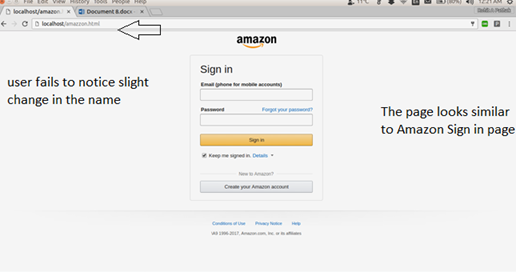

In [446]:
from IPython.display import Image
Image("./Image1.png")

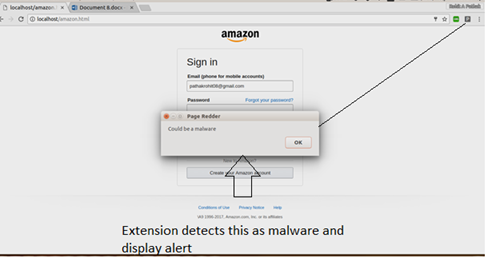

In [447]:
Image("./Image2.png")

In [ ]:
#references
https://en.wikipedia.org/wiki/Phishing